In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt

In [2]:
sess = tf.InteractiveSession()

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

# quick fn to plot images
imshow = lambda img : plt.imshow(1 - img.reshape((img.shape[1], img.shape[2])),
                                 cmap='Greys_r',interpolation='nearest')

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
test_img = tf.reshape(mnist.train.images[1], [1,28,28,1])

In [5]:
maxpool, argmax = tf.nn.max_pool_with_argmax(test_img,
                                             [1,2,2,1],
                                             [1,2,2,1],
                                            padding='SAME')

In [49]:
unpool = tf.Variable(tf.zeros([784]))
maxflat = tf.reshape(maxpool, [196,])
argflat = tf.reshape(argmax, [196,])

unpool.initializer.run()

In [50]:
unpool = tf.reshape(tf.scatter_update(unpool, argflat, maxflat), [1,28,28,1])

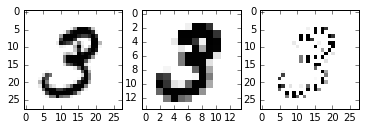

In [51]:
plt.subplot(1,3,1)
imshow(test_img.eval())
plt.subplot(1,3,2)
imshow(maxpool.eval())
plt.subplot(1,3,3)
imshow(unpool.eval())

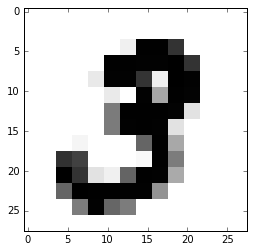

In [29]:
upsample = tf.image.resize_nearest_neighbor(maxpool, size=[28,28])
mask = tf.cast(tf.ones_like(upsample), tf.bool)
unpool = tf.select(mask, upsample, upsample)
imshow(unpool.eval())

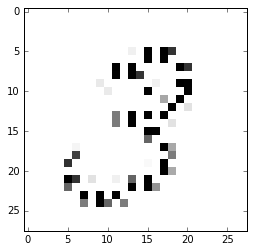

In [60]:
#sparse = tf.SparseTensor(indices=argflat, values=, shape=[784])
sparse = tf.sparse_to_dense(argflat, [784], maxflat, validate_indices=False)
#dense = tf.sparse_tensor_to_dense(sparse)
#sparse.eval()
reshaped = tf.reshape(sparse, [1,28,28,1])
#dense.eval()
#v = tf.Variable(reshaped)
#v.initializer.run()

imshow(reshaped.eval())

In [31]:
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops
@ops.RegisterGradient("MaxPoolWithArgmax")
def _MaxPoolGrad(op, grad):
  return gen_nn_ops._max_pool_grad(op.inputs[0],
                                   op.outputs[0],
                                   grad,
                                   op.get_attr("ksize"),
                                   op.get_attr("strides"),
                                   padding=op.get_attr("padding"),
                                   data_format=op.get_attr("data_format"))

In [10]:
from cae import flatten

In [11]:
def max_pool_argmax(name, input, padding='SAME'):
    maxpool, argmax = tf.nn.max_pool_with_argmax(input,
                                                 [1,2,2,1],
                                                 [1,2,2,1],
                                                 padding=padding)
    return (maxpool, argmax)
    
def argmax_unpool(name, maxpool, argmax, padding='SAME'):
    with tf.variable_scope(name) as scope:
        max_shape = [s.value for s in maxpool.get_shape()]
        
        maxflat = tf.reshape(maxpool, [-1, max_shape[1] * max_shape[2] * max_shape[3]])
        argflat = flatten('argflat',argmax)
        
        # unpooled shape will be 4 * pooled (for 2x2)
        flat_shape = 4 * maxflat.get_shape()[1].value
        unpool = tf.Variable(tf.zeros([flat_shape,]))
        unpool.initializer.run()
        
        unpool = tf.scatter_update(unpool, argflat, maxflat)
        unpool_shape = [-1, 2 * max_shape[1], 2 * max_shape[2], max_shape[3]]
        return tf.reshape(unpool, unpool_shape)

In [16]:
maxpool, argmax = max_pool_argmax('mp', test_img)
unpool = argmax_unpool('up', maxpool, argmax)

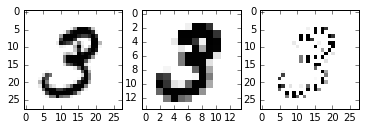

In [17]:
plt.subplot(1,3,1)
imshow(test_img.eval())
plt.subplot(1,3,2)
imshow(maxpool.eval())
plt.subplot(1,3,3)
imshow(unpool.eval())

In [18]:
@tf.ops.RegisterGradient("ScatterUpdate")
def _tf_reverse_grad(op, grad):
    reverse_dims = op.inputs[1]
    return tf.scatter_update(grad, reverse_dims), None

AttributeError: 'module' object has no attribute 'ops'